## conv autoencoder for mnist denoising

In [19]:
from tensorflow.examples.tutorials.mnist.input_data import read_data_sets
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, ModelCheckpoint

## prepare data

In [52]:
dataset_dir = os.path.join(os.path.expanduser('~'), 'bitbucket/test_data/mnist')
dataset = read_data_sets(dataset_dir)
train_images, train_labels = dataset.train.images, dataset.train.labels
test_images, test_labels = dataset.test.images, dataset.test.labels
train_images = np.asarray(train_images, dtype='float32').reshape((-1, 28, 28, 1))
test_images = np.asarray(test_images, dtype='float32').reshape((-1, 28, 28, 1))
print(train_images.shape, test_images.shape)
print(np.max(test_images), np.min(test_images))

Extracting /home/huizhu/bitbucket/test_data/mnist/train-images-idx3-ubyte.gz
Extracting /home/huizhu/bitbucket/test_data/mnist/train-labels-idx1-ubyte.gz
Extracting /home/huizhu/bitbucket/test_data/mnist/t10k-images-idx3-ubyte.gz
Extracting /home/huizhu/bitbucket/test_data/mnist/t10k-labels-idx1-ubyte.gz
((55000, 28, 28, 1), (10000, 28, 28, 1))
(1.0, 0.0)


## add noise

In [54]:
noise_factor = 0.5
train_images_noisy = train_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_images.shape) 
test_images_noisy = test_images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_images.shape)
train_images_noisy = np.clip(train_images_noisy, 0., 1.)
test_images_noisy = np.clip(test_images_noisy, 0., 1.)

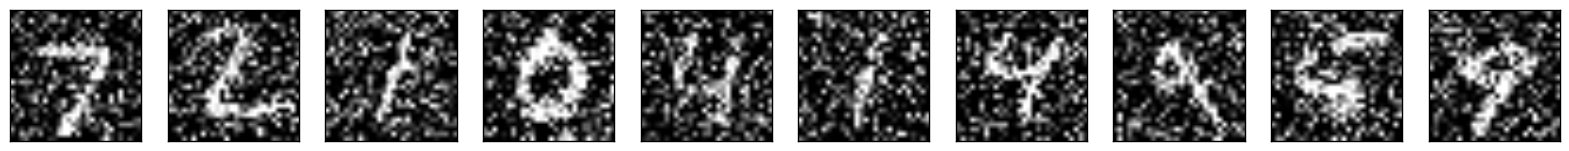

In [55]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(test_images_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [53]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

print(np.max(x_test), np.min(x_test))
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

(1.0, 0.0)


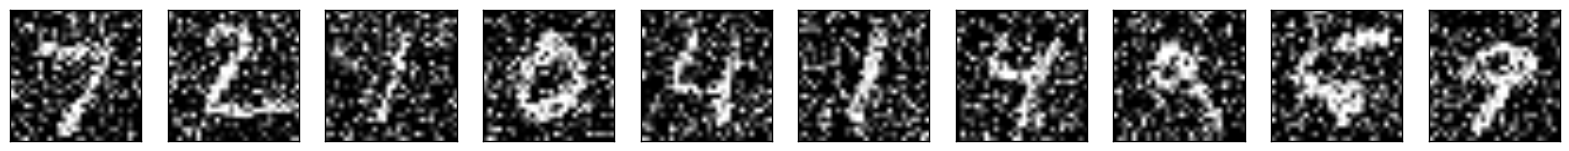

In [47]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## build conv autoencoder

In [6]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [1]:
import joblib
log_dir = os.path.join(dataset_dir, 'conv_autoencoder')
config_file = os.path.join(log_dir, 'config.joblib')
hdf5_file = os.path.join(log_dir, 'weights.hdf5')

joblib.dump(autoencoder.get_config(), config_file)
checkpoint = ModelCheckpoint(hdf5_file, save_best_only=True, period=2)
tensorboard = TensorBoard(log_dir, write_images=True, histogram_freq=1)
autoencoder.fit(train_images_noisy, train_images,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(test_images_noisy, test_images),
                callbacks=[tensorboard, checkpoint])

NameError: name 'os' is not defined